In [1]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

#nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

# Modelling
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC

#Lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation
sns.set(font_scale=1.3)
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/shamimkhan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [3]:
# Read datasets
df_train = pd.read_csv('/Users/shamimkhan/Downloads/lstm_dataset/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('/Users/shamimkhan/Downloads/lstm_dataset/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/Users/shamimkhan/Downloads/lstm_dataset/test.txt', names=['Text', 'Emotion'], sep=';')

In [4]:
df_train.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
#print the shape of the data set
print(df_train.shape)

(16000, 2)


In [6]:
#print first 5 rows
df_test.head()

,Text,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [7]:
#print the shape of the data set
print(df_test.shape)

(2000, 2)


In [8]:
#print first 5 rows
df_val.head()

,Text,Emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [9]:
#print the shape of the data set
print(df_val.shape)

(2000, 2)


In [10]:
#check if the data is balanced or not
df_train.Emotion.value_counts()

Emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [11]:
#check if the data is balanced or not
df_train.Emotion.value_counts() / df_train.shape[0] *100

Emotion
joy         33.51250
sadness     29.16250
anger       13.49375
fear        12.10625
love         8.15000
surprise     3.57500
Name: count, dtype: float64

<Axes: xlabel='Emotion', ylabel='count'>

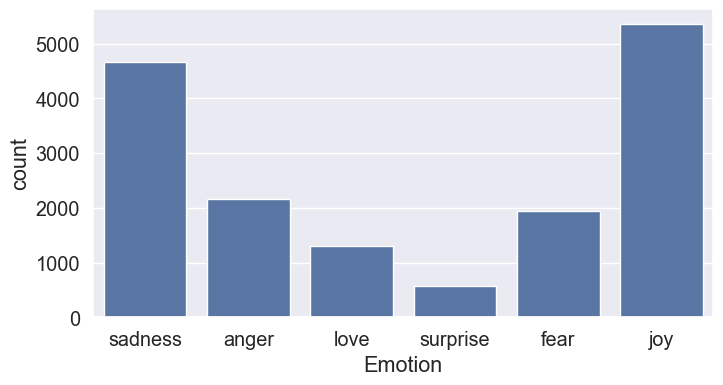

In [12]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_train)

The data is imbalanced so, we may try to balance it but also, the emotions that we interested in are the most repeated emotion so, till now we can keep the data as it is

In [13]:
#print the number of null values in each column
df_train.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [14]:
#print the number of duplicated values 
df_train.duplicated().sum()

np.int64(1)

In [15]:
#removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)


In [16]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train[df_train['Text'].duplicated() == True]

,Text,Emotion
5067,i feel on the verge of tears from weariness i ...,joy
6133,i still feel a craving for sweet food,love
6563,i tend to stop breathing when i m feeling stre...,anger
7623,i was intensely conscious of how much cash i h...,sadness
7685,im still not sure why reilly feels the need to...,surprise
8246,i am not amazing or great at photography but i...,love
9596,ive also made it with both sugar measurements ...,joy
9687,i had to choose the sleek and smoother feel of...,joy
9769,i often find myself feeling assaulted by a mul...,sadness
9786,i feel im being generous with that statement,joy


In [17]:
#print some of those rows to check
df_train[df_train['Text'] == df_train.iloc[7623]['Text']]

,Text,Emotion
1625,i was intensely conscious of how much cash i h...,anger
7623,i was intensely conscious of how much cash i h...,sadness


In [18]:
df_train[df_train['Text'] == df_train.iloc[14313]['Text']]

,Text,Emotion
13653,i could feel myself hit this strange foggy wall,fear
14313,i could feel myself hit this strange foggy wall,surprise


In [19]:
df_train[df_train['Text'] == df_train.iloc[13879]['Text']]

,Text,Emotion
7333,i feel like i am very passionate about youtube...,joy
13879,i feel like i am very passionate about youtube...,love


In [20]:
#removing duplicated text 
index = df_train[df_train['Text'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [21]:
#Count the number of stopwords in the data
temp =df_train.copy()
stop_words = set(stopwords.words("english"))
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

stop_words
5     1416
7     1405
6     1392
4     1341
8     1319
3     1263
9     1177
10    1048
2      922
11     889
12     752
13     644
14     493
1      450
15     376
16     265
17     238
18     164
19     113
20      90
0       79
21      60
22      33
23      19
24       7
25       6
26       6
28       1
29       1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

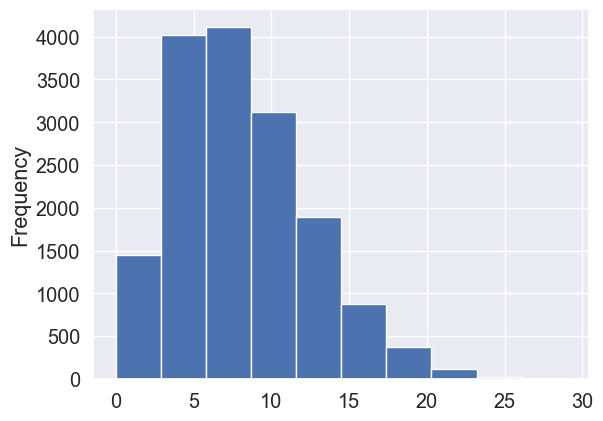

In [22]:
#distribution of stopwords visually
temp['stop_words'].plot(kind= 'hist')

In [23]:
#check if the data is balanced or not
df_test.Emotion.value_counts()

Emotion
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

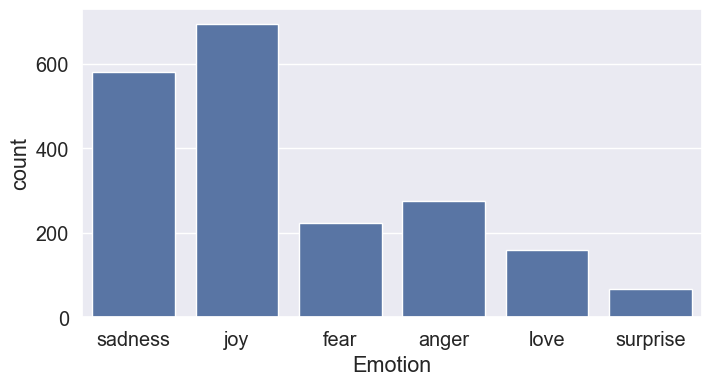

In [24]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_test);

In [25]:
#print the number of null values in each column
df_test.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [26]:
#print the number of duplicated values 
df_test.duplicated().sum()


np.int64(0)

In [27]:
#print the rows which are duplicated
df_test[df_test['Text'].duplicated() == True]


,Text,Emotion


In [28]:
#Count the number of stopwords in the data
temp =df_test.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()


stop_words
7     184
6     179
3     175
5     175
4     163
9     163
8     139
10    123
2     118
11    115
12     84
13     71
15     61
14     58
1      42
16     40
17     31
18     22
20     17
19     11
21     10
0       8
23      7
24      2
22      2
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

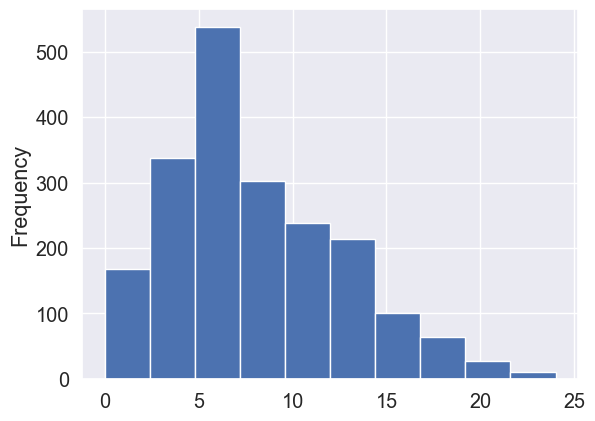

In [29]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist')

In [30]:
#check if the data is balanced or not
df_val.Emotion.value_counts()

Emotion
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64

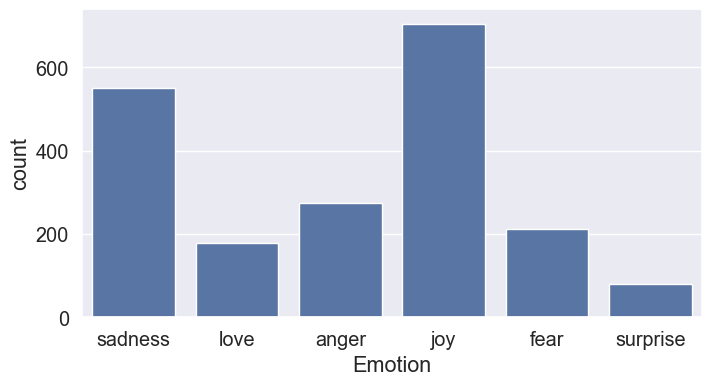

In [31]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_val);

In [32]:
#print the number of null values in each column
df_val.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [33]:
#print the number of duplicated values 
df_val.duplicated().sum()

np.int64(0)

In [34]:
#print the rows which are duplicated
df_val[df_val['Text'].duplicated() == True]

,Text,Emotion
603,i have had several new members tell me how com...,joy
1993,i feel so tortured by it,anger


In [35]:
df_val[df_val['Text'] == df_val.iloc[603]['Text']]

,Text,Emotion
300,i have had several new members tell me how com...,love
603,i have had several new members tell me how com...,joy


In [36]:
df_val[df_val['Text'] == df_val.iloc[1993]['Text']]

,Text,Emotion
774,i feel so tortured by it,fear
1993,i feel so tortured by it,anger


In [37]:
#removing duplicated text
index = df_val[df_val['Text'].duplicated() == True].index
df_val.drop(index, axis = 0, inplace = True)
df_val.reset_index(inplace=True, drop = True)

In [38]:
#Count the number of stopwords in the data
temp =df_val.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()[:10]

stop_words
7     190
5     175
8     173
6     160
3     160
10    150
9     146
4     145
2     133
11    103
Name: count, dtype: int64

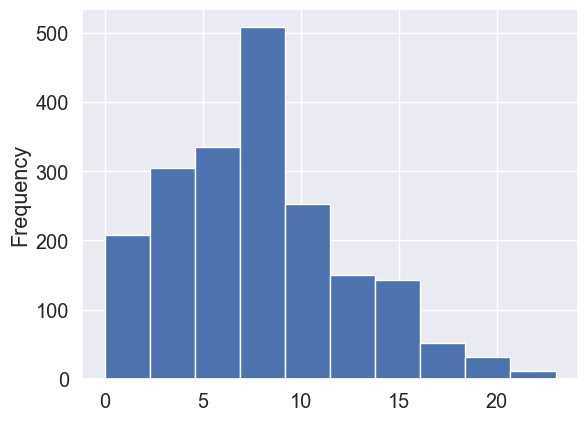

In [39]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist');

In [40]:
def dataframe_difference(df1, df2, which=None):
    """Find rows which are different between two DataFrames."""
    
    # Combine the two DataFrames using a merge operation, with the
    # indicator parameter set to True. This adds a column called _merge
    # to the resulting DataFrame, which indicates the source of each row.
    comparison_df = df1.merge(
        df2,
        indicator=True,
        how='outer'
    )
    
    # Filter the merged DataFrame based on the value of _merge. If which
    # is not specified, return all rows where _merge is not 'both'.
    # Otherwise, return all rows where _merge has the specified value
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
        
    # Return the filtered DataFrame
    return diff_df

In [41]:
dataframe_difference(df_train, df_test, which='both')

,Text,Emotion,_merge


In [42]:
dataframe_difference(df_train, df_val, which='both')

,Text,Emotion,_merge


In [43]:
dataframe_difference(df_val, df_test, which='both')

,Text,Emotion,_merge


In [44]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shamimkhan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [45]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]
    
    return " " .join(text)

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    
    text = text.split()
    text=[y.lower() for y in text]
    
    return " " .join(text)

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan

def normalize_text(df):
    df.Text=df.Text.apply(lambda text : lower_case(text))
    df.Text=df.Text.apply(lambda text : remove_stop_words(text))
    df.Text=df.Text.apply(lambda text : Removing_numbers(text))
    df.Text=df.Text.apply(lambda text : Removing_punctuations(text))
    df.Text=df.Text.apply(lambda text : Removing_urls(text))
    df.Text=df.Text.apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence

<>:28: SyntaxWarning: invalid escape sequence '\]'
<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\]'
<>:32: SyntaxWarning: invalid escape sequence '\s'
/var/folders/b5/037wx_rd5m53vrp56k8tznf00000gn/T/ipykernel_20433/1208390682.py:28: SyntaxWarning: invalid escape sequence '\]'
  text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
/var/folders/b5/037wx_rd5m53vrp56k8tznf00000gn/T/ipykernel_20433/1208390682.py:32: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)


In [46]:
normalized_sentence("My Name is Mohamed. @Tweets,  plays 2022  Egypt_")

'name mohamed tweet play egypt'

In [47]:
df_train= normalize_text(df_train)
df_test= normalize_text(df_test)
df_val= normalize_text(df_val)

Word embedding using this glove and use a sequance model

In [48]:
#Splitting the text from the labels
X_train = df_train['Text']
y_train = df_train['Emotion']

X_test = df_test['Text']
y_test = df_test['Emotion']

X_val = df_val['Text']
y_val = df_val['Emotion']

In [49]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [50]:
#print the labels after encoding 
print(set(y_train.tolist()))

{0, 1, 2, 3, 4, 5}


In [51]:
#Convert the class vector (integers) to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)


In [52]:
print(y_train)


[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


In [53]:
# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))


In [54]:
#word index: A dictionary of words and their uniquely assigned integers.
#tokenizer.word_index

In [55]:
#word counts: A dictionary of words and their counts.
#tokenizer.word_counts

In [56]:
#document count: A dictionary of words and how many documents each appeared in.
#in this dataset the output will be the number of rows
tokenizer.document_count

17969

In [57]:
#word docs: An integer count of the total number of documents(or rows) that were used to fit the Tokenizer.
#tokenizer.word_docs

In [58]:
#print the index of a single word
tokenizer.word_index['towards']

220

In [59]:
#converting a single sentence to list of indexes
tokenizer.texts_to_sequences(X_train[0].split())

[[53], [2], [531]]

In [60]:
#convert the list of indexes into a matrix of ones and zeros (BOW)
tokenizer.texts_to_matrix(X_train[0].split())

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(3, 14332))

In [61]:
#the sentence contains three words and the size of the vocabulary is 14325
tokenizer.texts_to_matrix(X_train[0].split()).shape

(3, 14332)

In [62]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

In [63]:
#print the sentence after converting them to indexes
#sequences_train

# Padding
The vectors we obtain are generally not of equal lengths

For that, we might need to pad the sequences to max len.

In [64]:
df_test.shape

(2000, 2)

In [65]:
maxlen = max([len(t) for t in df_train['Text']])
maxlen

229

In [66]:
X_train = pad_sequences(sequences_train, maxlen=229, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=229, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=229, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 14332


In [67]:
#before
sequences_train[0]

[53, 2, 531]

In [68]:
#after
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

# Word Embedding
This code defines the following variables:

path_to_glove_file: The file path to the GloVe word vectors file.

num_tokens: The size of the vocabulary. This is typically the number of unique words in the dataset.

embedding_dim: The dimensionality of the word vectors. This is usually set to a fixed value (e.g., 200, 300, etc.) depending on the size of the word vectors file that is being used.

hits: A counter for the number of words that are found in the embeddings_index dictionary.

misses: A counter for the number of words that are not found in the embeddings_index dictionary.

embeddings_index: A dictionary that will store the word vectors, with the words as keys and the word vectors as values.

In [69]:
# Read GloVE embeddings

path_to_glove_file = '/Users/shamimkhan/Downloads/glove_data/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200 #latent factors or features  
hits = 0
misses = 0
embeddings_index = {}

In [70]:
# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 13249 words (1082 misses)


In [78]:
import tensorflow as tf

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (1, 229, 200)          │     2,866,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (1, 229, 512)          │       935,936 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (1, 229, 256)          │       656,384 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (1, 256)               │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (1, 6)                 │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,854,502 (18.52 MB)

 Trainable params: 1,988,102 (7.58 MB)

 Non-trainable params: 2,866,400 (10.93 MB)

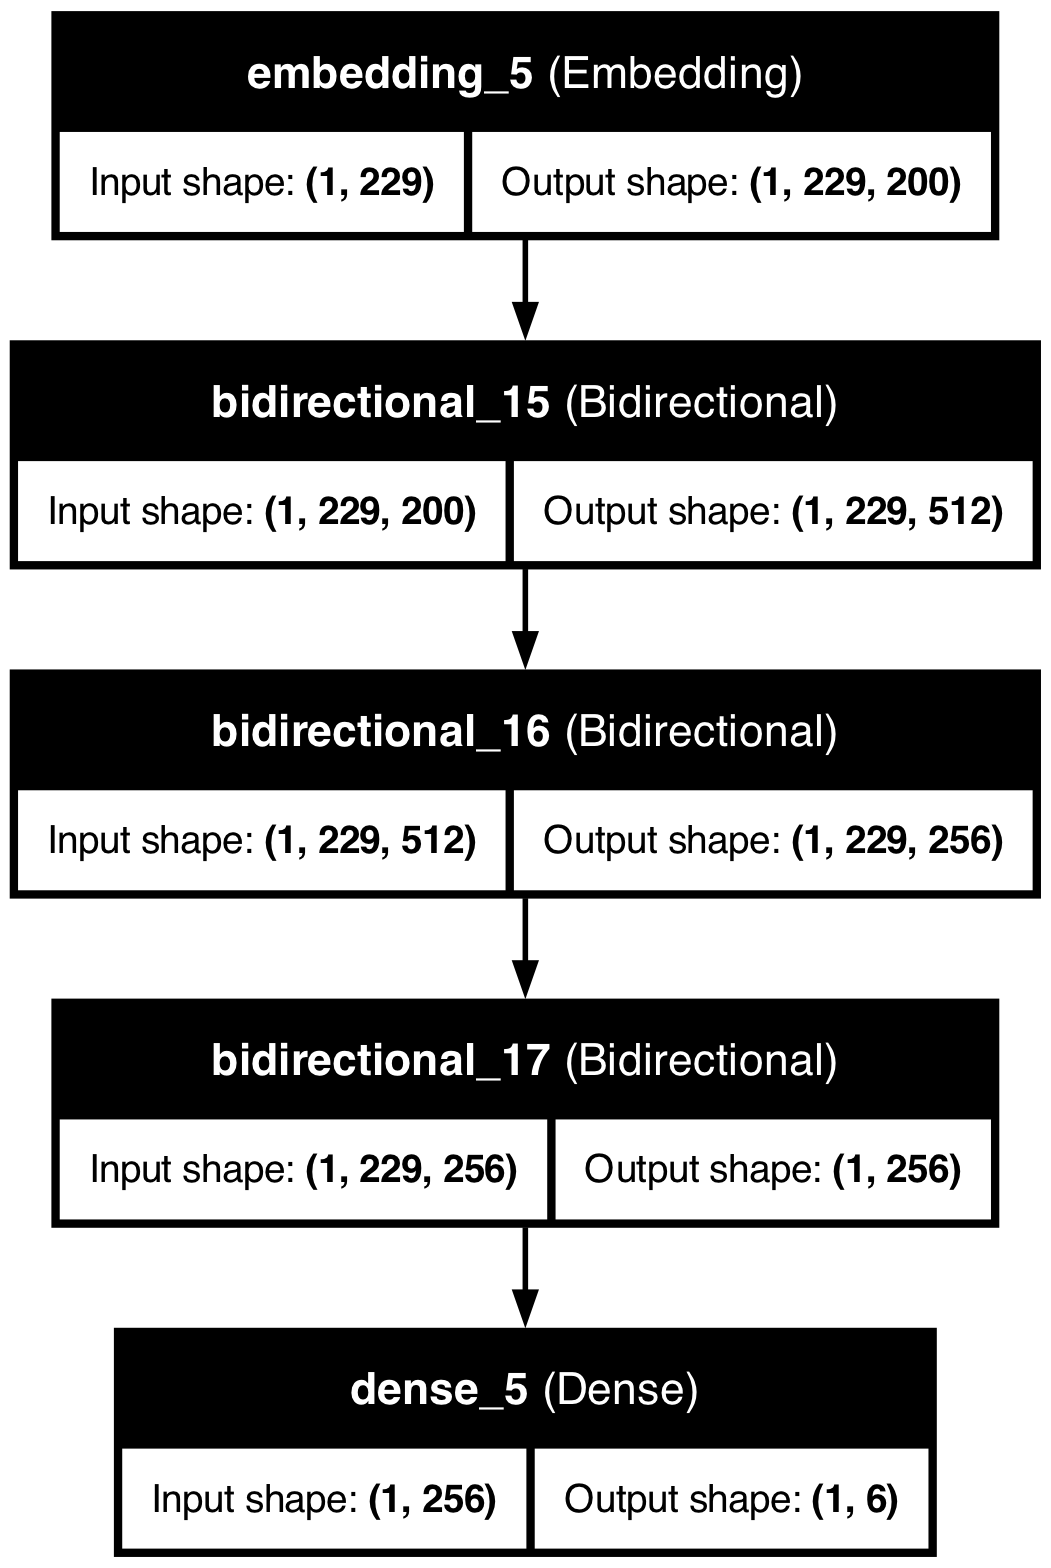

Model plot created and displayed.


In [79]:
adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], 
                    weights=[embedding_matrix], trainable=False))

model.add(Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2, 
                             return_sequences=True)))

model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, 
                             return_sequences=True)))

model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))

model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# ---- IMPORTANT: Build the model ----
model(tf.zeros((1, X_train.shape[1])))

# Now summary will show full shapes
model.summary()

# ---- Plot the model ----
try:
    plot_model(
        model, 
        to_file='model_plot.png', 
        show_shapes=True, 
        show_layer_names=True
    )
    display(Image(filename='model_plot.png'))
    print("Model plot created and displayed.")
except Exception as e:
    print(f"An error occurred while plotting: {e}")


In [80]:
#to stop the training when the loss starts to increase
callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
)

In [81]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=256,
                    epochs=30,
                    callbacks=[callback]
                   )

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 797s 13s/step - accuracy: 0.5625 - loss: 1.1741 - val_accuracy: 0.8078 - val_loss: 0.5459
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1337s 21s/step - accuracy: 0.8384 - loss: 0.4475 - val_accuracy: 0.9094 - val_loss: 0.2696
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 677s 11s/step - accuracy: 0.9056 - loss: 0.2410 - val_accuracy: 0.9229 - val_loss: 0.2032
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 779s 12s/step - accuracy: 0.9287 - loss: 0.1613 - val_accuracy: 0.9299 - val_loss: 0.1389
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1171s 19s/step - accuracy: 0.9426 - loss: 0.1267 - val_accuracy: 0.9294 - val_loss: 0.1416
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 724s 12s/step - accuracy: 0.9473 - loss: 0.1085 - val_accuracy: 0.9334 - val_loss: 0.1416
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 737s 12s/step - accuracy: 0.9530 - loss: 0.0950 - val_accuracy: 0.9389 - val_loss: 0.1274
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 700s 11s/step - accuracy: 0.9534 - loss: 0.0977 - val_accuracy: 

In [82]:
#print the overall loss and accuracy
model.evaluate(X_val, y_val, verbose=1) 

63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 458ms/step - accuracy: 0.9389 - loss: 0.1274


[0.12744176387786865, 0.9389389157295227]

In [83]:
#print the overall loss and accuracy
model.evaluate(X_test, y_test, verbose=1) 

63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 464ms/step - accuracy: 0.9275 - loss: 0.1559


[0.15594787895679474, 0.9275000095367432]

In [84]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)

print(classification_report(le.transform(df_test['Emotion']), y_pred))

63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 480ms/step
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       275
           1       0.87      0.96      0.91       224
           2       0.92      0.96      0.94       695
           3       0.90      0.72      0.80       159
           4       0.96      0.97      0.96       581
           5       0.83      0.65      0.73        66

    accuracy                           0.93      2000
   macro avg       0.91      0.86      0.88      2000
weighted avg       0.93      0.93      0.93      2000



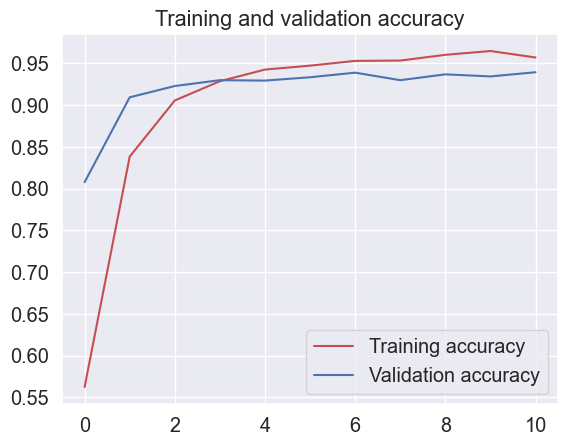

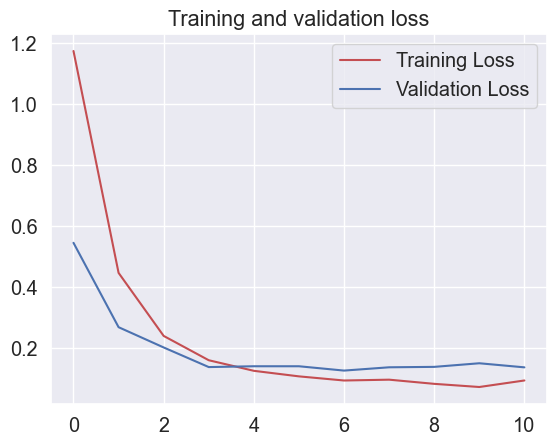

In [85]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [86]:
# Classify custom sample

sentences = [
            "He's over the moon about being accepted to the university",
            "Your point on this certain matter made me outrageous, how can you say so? This is insane.",
            "I can't do it, I'm not ready to lose anything, just leave me alone",
            "Merlin's beard harry, you can cast the Patronus charm! I'm amazed!"
            ]
for sentence in sentences:
    print(sentence)
    sentence = normalized_sentence(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

He's over the moon about being accepted to the university
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
joy : 0.9577549695968628


Your point on this certain matter made me outrageous, how can you say so? This is insane.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
anger : 0.5495238304138184


I can't do it, I'm not ready to lose anything, just leave me alone
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
fear : 0.3327075242996216


Merlin's beard harry, you can cast the Patronus charm! I'm amazed!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
surprise : 0.899651825428009




In [87]:
sentence= 'my old brother is dead'
print(sentence)
sentence = normalized_sentence(sentence)
sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
proba =  np.max(model.predict(sentence))
print(f"{result} : {proba}\n\n")

my old brother is dead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
sadness : 0.6313583254814148




In [88]:
sentence= 'Im feeling sad today'
print(sentence)
sentence = normalized_sentence(sentence)
sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
proba =  np.max(model.predict(sentence))
print(f"{result} : {proba}\n\n")

Im feeling sad today
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
sadness : 0.9995294809341431




In [89]:
model.save('Emotion Recognition From English text.h5')